In [1]:
import json
import torch
import itertools
from pathlib import Path
import matplotlib.pyplot as plt
import os
import shutil

RESULTS_FOLDER = Path("results")

def exp_to_hist(exp, groups=[(4, 7, 9), (4, 5, 8)]):
    m = torch.load(exp / "confusion_matrix.pt")
    hist = {}
    for group_ind, group in enumerate(groups):
        for i, j in itertools.combinations(group, 2):
            hist[f"{group_ind}: {i}-{j}"] = m[i][j] + m[j][i]
    return hist
    
def plot_confusion(hist, name):
    plt.figure(figsize=(10, 6))
    plt.bar(hist.keys(), hist.values())
    plt.xlabel("Index Pairs")
    plt.ylabel("Average Value")
    plt.title(name)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


def average_on(param: str, value):
    hist = {}
    amount = 0
    for exp_path in RESULTS_FOLDER.iterdir():
        conditions_path = exp_path / "conditions.json"
        if not conditions_path.exists():
            continue

        with open(conditions_path) as f:
            metadata = json.load(f)

        if metadata.get(param) == value:
            for key, val in exp_to_hist(exp_path).items():
                hist[key] = hist.get(key, 0) + val
            amount += 1

    for key in hist:
        hist[key] /= amount
    plot_confusion(hist, f"Average Histogram for '{param}' = '{value}' (averaged over {amount} experiments)")

name = "exp_23-06-2025_12-01"
#plot_confusion(exp_to_hist(RESULTS_FOLDER / name), name)

In [2]:
import os
DIR_RESULTS = "results"
def const_diff_layers(num_layers, extra_condition = "exp"):
    for file in os.listdir(DIR_RESULTS):
        filename = os.fsdecode(file)
        if os.path.isdir(os.path.join(DIR_RESULTS, filename)): ## OS DECODE?    
            results_folder = f'{DIR_RESULTS}/{filename}'
            conditions_file = f'{results_folder}/conditions.json'
            if os.path.exists(conditions_file):
                with open(conditions_file) as json_file:
                    loaded_var = json.load(json_file)
                if extra_condition not in filename:
                    continue
                if 'num_diff_layers' in loaded_var.keys() and loaded_var['num_diff_layers'] == num_layers:
                    yield filename
                
                if 'number_of_diff_layers' in loaded_var.keys() and loaded_var['number_of_diff_layers'] == num_layers:
                    yield filename

In [3]:
print(*const_diff_layers(1))

exp_zones_23-06-2025_23-03 exp_zones_23-06-2025_18-23 exp_23-06-2025_12-42 exp_23-06-2025_13-23 exp_zones_23-06-2025_18-47 exp_23-06-2025_12-01


/tmp/ipykernel_24212/2860217256.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('rainbow')


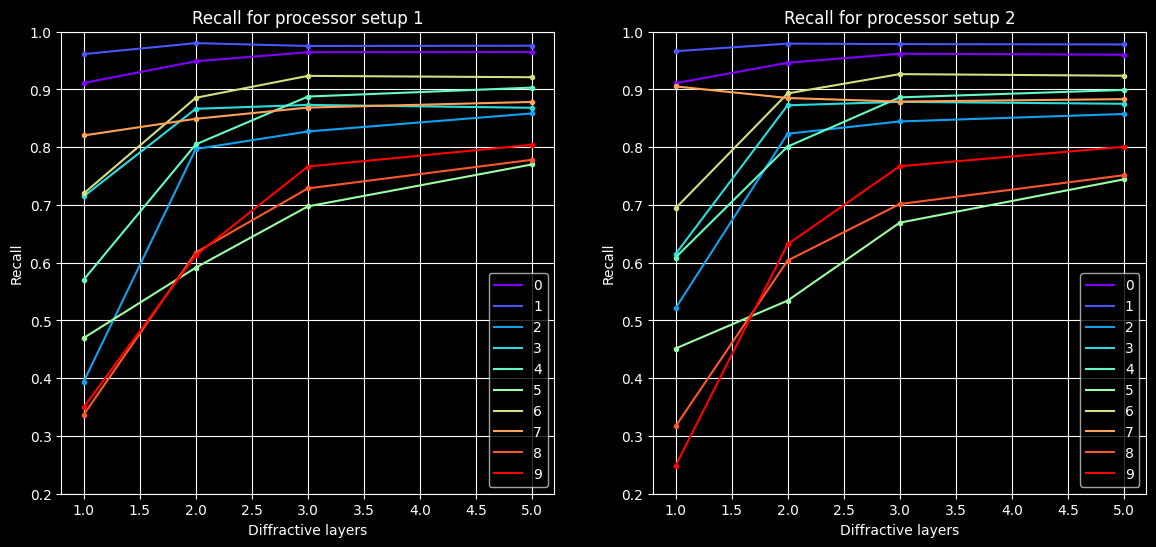

In [4]:
import matplotlib.cm as cm
import numpy as np

def plot_filtered(ax, filt, title, prec=False):
    def digit_acc(digit, exp):
        try:
            m = torch.load(RESULTS_FOLDER / exp / "confusion_matrix.pt")
        except:
            return None
        if prec:
            return m[digit][digit] / sum(m[i][digit] for i in range(len(m[9])))
        else:
            return m[digit][digit] / sum(m[digit])
    colormap = cm.get_cmap('rainbow')
    gradient_values = np.linspace(0, 1, 10)
    colors = [colormap(value) for value in gradient_values]
    
    def plot_digit(i):
        avg_accs = []
        rng = []
        for diff_layer in range(1, 6):
            avg_acc = 0
            filtered_exps = list(const_diff_layers(diff_layer, filt))
            with_matrix = 0
            for exp in filtered_exps:
                acc = digit_acc(i, exp)
                if acc:
                    avg_acc += acc
                    with_matrix += 1
            if with_matrix != 0:
                ax.plot([diff_layer], [avg_acc / with_matrix], '.', color=colors[i])
                avg_accs.append(avg_acc / with_matrix)
                rng.append(diff_layer)
        ax.plot(rng, avg_accs, color=colors[i], label=i)
        return avg_accs
    # TODO: Fix no-experiment issue
    digit_lists = []
    for i in range(10):
        digit_lists.append(plot_digit(i))
    
    ax.set_title(title)
    ax.legend()
        # Add grid
    ax.grid(True)
    
    # Set y-axis scale from 0 to 1 (for accuracy)
    if prec:
        ax.set_ylim(0.5, 1)
    else:
        ax.set_ylim(0.2, 1)
    ax.set_ylabel("Precision" if prec else "Recall")
    ax.set_xlabel("Diffractive layers")
    # Set x-axis scale if desired (e.g., from 0.5 to 5.5 to encompass diff_layer range)
    # You might adjust the x-axis limits based on your 'diff_layer' range.
    return digit_lists
plt.style.use('dark_background')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
dl1 = plot_filtered(axes[0], "exp_2", "Recall for processor setup 1", prec=False) # [[layers] * digits]
dl2 = plot_filtered(axes[1], "zones", "Recall for processor setup 2",  prec=False)
plt.show()


/tmp/ipykernel_24212/2860217256.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('rainbow')


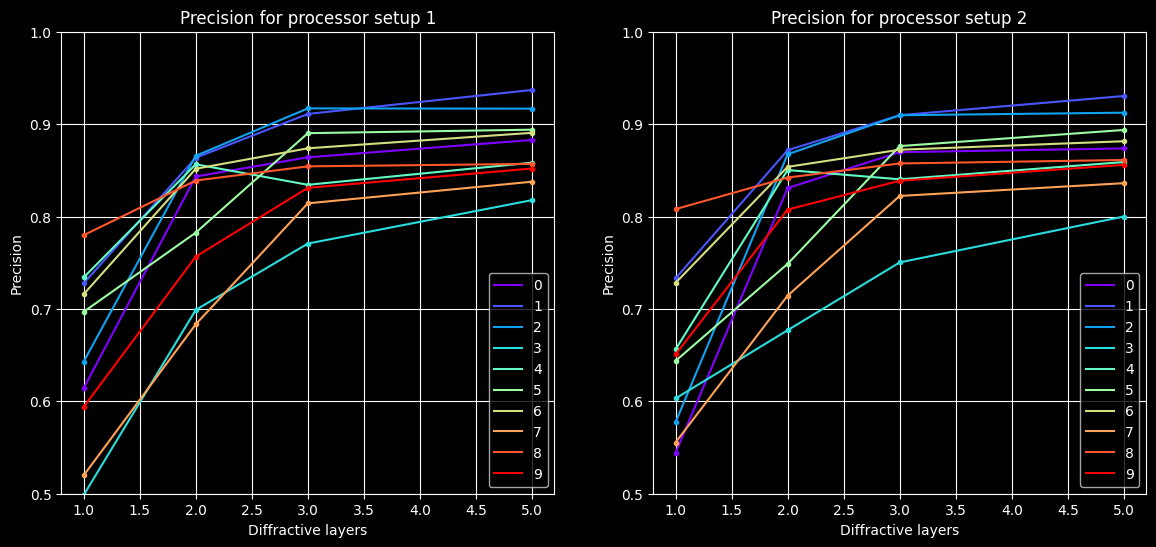

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
dl1 = plot_filtered(axes[0], "exp_2", "Precision for processor setup 1", prec=True) # [[layers] * digits]
dl2 = plot_filtered(axes[1], "zones", "Precision for processor setup 2",  prec=True)
plt.show()

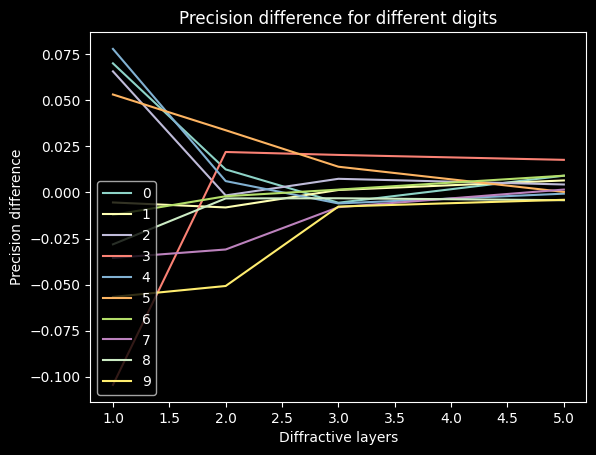

In [109]:
for i, (digit1_list, digit2_list) in enumerate(zip(dl1, dl2)):
    data = [digit1_list[i] - digit2_list[i] for i in range(len(digit2_list))]
    plt.plot([1, 2, 3, 5], data, label=i)
    plt.title("Precision difference for different digits")
    plt.xlabel("Diffractive layers")
    plt.ylabel("Precision difference")

plt.legend()